In [7]:
import CalculatedFieldSubroutines as cfs

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from pandasgui import show

import matplotlib.pyplot as plt

import seaborn as sns

import warnings

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
#import in neede libraries

In [8]:
warnings.filterwarnings( 'ignore' )

In [9]:
gmID_list = cfs.list_whitelisted_gmIDs()

topic_list = cfs.list_topics()

print( topic_list )

['/apollo/drive/event', '/apollo/perception/traffic/light', '/apollo/canbus/chassis', '/apollo/sensor/gnss/best/pose']


In [10]:
red_combined_dfs = []

for gmID in gmID_list:

    if ( cfs.give_route( gmID ) != 'Red' ):

        continue

    chassis_df = cfs.retrieve_gmID_topic( gmID, '/apollo/canbus/chassis' )

    best_pose_df = cfs.retrieve_gmID_topic( gmID, '/apollo/sensor/gnss/best/pose' )

    chassis_df.sort_values( 'time' )

    best_pose_df.sort_values( 'time' )

    #

    cfs.BinaryDrivingMode( chassis_df )

    cfs.TernaryDrivingModeTransition( chassis_df )

    cfs.DistanceToNearestDisengagement( chassis_df )

    #

    cfs.LatLonTotalStdDev( best_pose_df )

    cfs.ProgressAlongRoute_v2( best_pose_df )

    #

    cfs.ChassisBestPoseMatchedTime( chassis_df, best_pose_df )

    #

    red_combined_df = pd.merge( chassis_df, best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

    #

    red_combined_df = red_combined_df[ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'longitude', 'latitude', \
                                 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber' ] ]

    red_combined_dfs.append( red_combined_df )

In [11]:
red_combined_df_all = pd.concat( red_combined_dfs )

In [12]:
red_combined_df_all_disengagements = red_combined_df_all[ red_combined_df_all[ 'TernaryDrivingModeTransition' ] == -1 ]


In [35]:
data = red_combined_df_all_disengagements[ [ 'brakePercentage', 'speedMps', 'throttlePercentage', 'steeringPercentage','LatLonTotalStdDev' ] ].copy()


In [36]:
data

,brakePercentage,speedMps,throttlePercentage,steeringPercentage,LatLonTotalStdDev
1096,0.0,24.03,0.0,-3.819785,0.128524
2594,22.1,22.36,0.0,-0.460333,0.033013
5271,0.9,14.69,16.2,0.577865,0.017625
6770,26.2,18.71,0.0,-2.321254,0.577488
46511,0.9,25.54,41.8,-1.224290,0.023725
...,...,...,...,...,...
37857,12.7,0.00,0.0,-74.221350,0.014786
38531,14.8,25.78,0.0,-0.186092,0.014740
40733,0.0,26.84,20.6,0.989226,0.013315
46305,0.0,24.59,4.1,-0.235064,0.014761


In [37]:
data = ((data - data.min())/(data.max()-data.min())) * 9 + 1

In [38]:
data.describe()

,brakePercentage,speedMps,throttlePercentage,steeringPercentage,LatLonTotalStdDev
count,645.000000,645.000000,645.000000,645.000000,645.000000
mean,1.595235,6.101970,2.532288,8.506928,1.044453
std,1.564382,2.101785,2.369135,0.963310,0.377376
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,4.949761,1.000000,8.548630,1.000348
50%,1.000000,6.359903,1.000000,8.784878,1.000773
75%,1.000000,7.832231,3.538000,8.858293,1.006487
max,10.000000,10.000000,10.000000,10.000000,10.000000


In [39]:
def random_centroids(data,k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)
#a function that will take in the number of clusters we want with our data
#initialize a list called centroids for i in range k
#then add it to the list of centroids
#the number of centroids is equivalent to the number of clusters we want
#combines all of the centroids(individual pandas series) into a data frame

In [40]:
centroids = random_centroids(data,5)
#we can now run the random_centroids

In [41]:
centroids

,0,1,2,3,4
brakePercentage,1.000000,1.000000,1.000000,1.000000,1.000000
speedMps,6.450748,4.790463,2.575825,3.960320,4.818656
throttlePercentage,1.000000,1.000000,6.859000,1.000000,1.000000
steeringPercentage,8.599456,8.878059,9.669630,8.777348,2.757908
LatLonTotalStdDev,1.000973,1.000552,1.000547,1.017682,1.000968


In [42]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)
#label each data point 
#finds the euclidean distance between a data point and each cluster for all centroids 
#finding which cluster center is closest to that point 

In [43]:
labels = get_labels(data, centroids)

In [44]:
labels.value_counts()
#how many times each value occurs 

0    359
2     95
1     94
3     84
4     13
Name: count, dtype: int64

In [45]:
def new_centroids(data, labels, k):
    centroids = data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    return centroids
#splits the data by each cluster and then calculate a new center for each group

In [46]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()
#Using PCA to change the multidimensional values into 2-D data
#Pass in the several column data and get it converted into 2 column data
#plotting the clusters and coloring from the plotting of centroids 
#will wait and change the graph over the already completed graph 

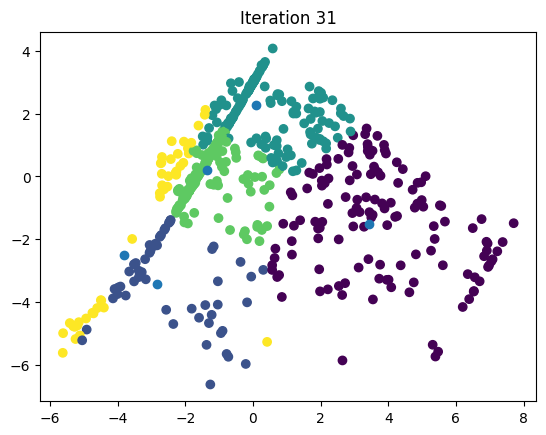

In [47]:
max_iterations = 100
centroid_count = 5

centroids = random_centroids(data, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    
    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, centroid_count)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1
#when new centroids are equilavent to past centroids (indicates that it has stopped shifting)
#update the data to see which label corresponds with each cluster

In [48]:
c0 = red_combined_df_all_disengagements[labels ==0][ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'longitude', 'latitude', \
                                 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber' ] ]
c1 = red_combined_df_all_disengagements[labels ==1][ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'longitude', 'latitude', \
                                 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber' ] ]
c2 = red_combined_df_all_disengagements[labels ==2][ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'longitude', 'latitude', \
                                 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber' ] ]
c3 = red_combined_df_all_disengagements[labels ==3][ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'longitude', 'latitude', \
                                 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber' ] ]
c4 = red_combined_df_all_disengagements[labels ==4][ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'longitude', 'latitude', \
                                 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber' ] ]

In [49]:
c0.describe()

,brakePercentage,speedMps,time_x,throttlePercentage,steeringPercentage,TernaryDrivingModeTransition,DistanceToNearestDisengagement,longitude,latitude,LatLonTotalStdDev,ProgressAlongRoute,PartitionNumber
count,134.000000,134.000000,1.340000e+02,134.000000,134.000000,134.0,134.0,134.000000,134.000000,134.000000,134.000000,134.000000
mean,0.981343,17.931936,1.699250e+18,61.083582,-0.148860,-1.0,0.0,-82.052339,39.349051,0.240011,0.660368,65.567164
std,3.628628,5.092272,6.130995e+15,21.626693,1.821562,0.0,0.0,0.041169,0.021367,0.876383,0.288026,28.780332
min,0.000000,3.460000,1.684870e+18,29.800000,-10.597453,-1.0,0.0,-82.104942,39.324416,0.009288,0.002080,0.000000
25%,0.000000,14.015000,1.693935e+18,43.925000,-0.478826,-1.0,0.0,-82.083010,39.332314,0.014728,0.514427,51.000000
50%,0.000000,18.715000,1.697561e+18,55.750000,-0.058766,-1.0,0.0,-82.072699,39.340165,0.017526,0.733259,73.000000
75%,0.000000,22.297500,1.705602e+18,75.775000,0.584239,-1.0,0.0,-82.009382,39.358137,0.023567,0.881970,87.750000
max,24.000000,25.890000,1.708627e+18,100.000000,3.751224,-1.0,0.0,-81.979149,39.404473,7.290407,0.996885,99.000000


In [50]:
c1.describe()

,brakePercentage,speedMps,time_x,throttlePercentage,steeringPercentage,TernaryDrivingModeTransition,DistanceToNearestDisengagement,longitude,latitude,LatLonTotalStdDev,ProgressAlongRoute,PartitionNumber
count,54.000000,54.000000,5.400000e+01,54.000000,54.000000,54.0,54.0,54.000000,54.000000,54.000000,54.000000,54.000000
mean,3.116667,3.619498,1.698190e+18,12.109259,-19.300665,-1.0,0.0,-82.045410,39.353610,0.041121,0.725501,72.037037
std,5.609855,3.322443,4.936902e+15,15.642314,17.400555,0.0,0.0,0.057091,0.021575,0.144599,0.260043,26.009405
min,0.000000,0.000000,1.690913e+18,0.000000,-74.221350,-1.0,0.0,-82.105812,39.324333,0.010724,0.000000,0.000000
25%,0.000000,0.413412,1.694754e+18,0.000000,-29.591088,-1.0,0.0,-82.105706,39.324415,0.013708,0.606025,60.000000
50%,0.000000,2.434254,1.697174e+18,0.000000,-18.457394,-1.0,0.0,-81.995172,39.362197,0.014961,0.606747,60.000000
75%,0.775000,6.990000,1.702230e+18,26.625000,-5.360991,-1.0,0.0,-81.995016,39.362477,0.016219,0.989959,98.000000
max,16.600000,8.890000,1.708627e+18,47.000000,2.723603,-1.0,0.0,-81.980715,39.385321,1.016193,0.990977,99.000000


In [51]:
c2.describe()

,brakePercentage,speedMps,time_x,throttlePercentage,steeringPercentage,TernaryDrivingModeTransition,DistanceToNearestDisengagement,longitude,latitude,LatLonTotalStdDev,ProgressAlongRoute,PartitionNumber
count,185.000000,185.000000,1.850000e+02,185.000000,185.000000,185.0,185.0,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.743243,22.651174,1.698462e+18,7.791351,-0.022624,-1.0,0.0,-82.044890,39.361190,0.208843,0.510032,50.481081
std,5.219869,2.632384,6.231491e+15,11.262000,1.978627,0.0,0.0,0.037583,0.028702,0.777255,0.307461,30.729552
min,0.000000,17.480000,1.684868e+18,0.000000,-6.728697,-1.0,0.0,-82.103459,39.325675,0.010912,0.004935,0.000000
25%,0.000000,19.750000,1.693321e+18,0.000000,-0.744368,-1.0,0.0,-82.081425,39.333017,0.016524,0.224392,22.000000
50%,0.000000,23.390000,1.697561e+18,0.000000,-0.048972,-1.0,0.0,-82.042033,39.355976,0.022906,0.583942,58.000000
75%,0.000000,24.561644,1.705004e+18,17.200000,0.763957,-1.0,0.0,-82.012299,39.391811,0.047999,0.823296,82.000000
max,25.900000,28.730000,1.708627e+18,36.800000,6.523016,-1.0,0.0,-81.980489,39.404216,8.833416,0.979865,97.000000


In [52]:
c3.describe()

,brakePercentage,speedMps,time_x,throttlePercentage,steeringPercentage,TernaryDrivingModeTransition,DistanceToNearestDisengagement,longitude,latitude,LatLonTotalStdDev,ProgressAlongRoute,PartitionNumber
count,228.000000,228.000000,2.280000e+02,228.000000,228.000000,228.0,228.0,228.000000,228.000000,228.000000,227.000000,227.000000
mean,0.644298,14.202947,1.698557e+18,2.819298,-1.472401,-1.0,0.0,-82.015978,39.364585,2.111614,0.441323,43.634361
std,2.588421,2.687912,5.572286e+15,6.857497,5.351823,0.0,0.0,0.043395,0.022956,12.118266,0.227458,22.694650
min,0.000000,8.092452,1.684868e+18,0.000000,-18.031342,-1.0,0.0,-82.105542,39.324636,0.010753,0.000000,0.000000
25%,0.000000,12.012500,1.694107e+18,0.000000,-4.165034,-1.0,0.0,-82.052552,39.347740,0.026286,0.267161,26.500000
50%,0.000000,14.644883,1.696873e+18,0.000000,-0.328357,-1.0,0.0,-81.991858,39.363713,0.112156,0.501651,50.000000
75%,0.000000,16.590000,1.702484e+18,0.000000,0.817826,-1.0,0.0,-81.980680,39.388535,1.734669,0.528815,52.000000
max,20.000000,18.330000,1.708627e+18,28.900000,12.458374,-1.0,0.0,-81.979028,39.404470,173.560116,0.997795,99.000000


In [53]:
c4.describe()

,brakePercentage,speedMps,time_x,throttlePercentage,steeringPercentage,TernaryDrivingModeTransition,DistanceToNearestDisengagement,longitude,latitude,LatLonTotalStdDev,ProgressAlongRoute,PartitionNumber
count,44.000000,44.000000,4.400000e+01,44.000000,44.000000,44.0,44.0,44.000000,44.000000,44.000000,44.000000,44.000000
mean,30.218182,10.859081,1.698973e+18,1.320455,-13.261414,-1.0,0.0,-82.015703,39.360332,0.100437,0.478901,47.340909
std,7.604964,8.671990,5.938873e+15,8.367006,20.888208,0.0,0.0,0.043347,0.026214,0.346510,0.237759,23.701578
min,19.600000,0.000000,1.684868e+18,0.000000,-81.194910,-1.0,0.0,-82.103812,39.324332,0.010408,0.000000,0.000000
25%,25.175000,0.592500,1.694107e+18,0.000000,-29.196866,-1.0,0.0,-82.041339,39.327279,0.014722,0.386008,38.000000
50%,27.600000,14.185000,1.697568e+18,0.000000,-2.002938,-1.0,0.0,-81.994302,39.368091,0.017513,0.455877,45.000000
75%,33.150000,18.597500,1.705003e+18,0.000000,-0.154261,-1.0,0.0,-81.989722,39.385226,0.026169,0.606674,60.000000
max,49.200000,24.030000,1.708626e+18,55.500000,6.454456,-1.0,0.0,-81.980677,39.400395,2.210059,0.981108,98.000000


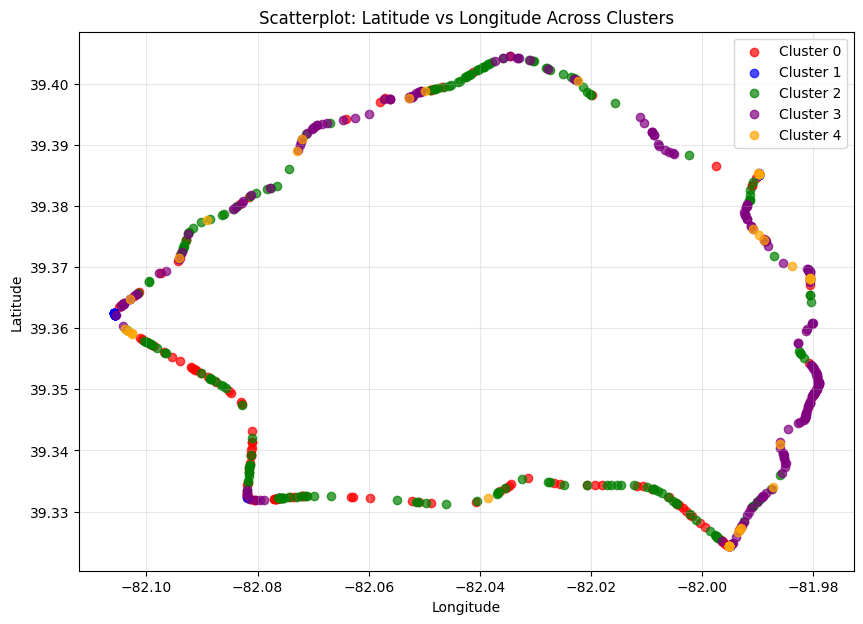

In [54]:
import matplotlib.pyplot as plt

# Define cluster data and colors
clusters = [c0, c1, c2, c3, c4]
colors = ['red', 'blue', 'green', 'purple', 'orange']
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

# Initialize plot
plt.figure(figsize=(10, 7))

# Plot each cluster using latitude and longitude
for i, cluster in enumerate(clusters):
    plt.scatter(cluster['longitude'], cluster['latitude'], 
                color=colors[i], label=labels[i], alpha=0.7)

# Add titles and labels
plt.title("Scatterplot: Latitude vs Longitude Across Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(alpha=0.3)

# Show plot
plt.show()
